In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def cumulative_matrix(m):
    """given a matrix m of probabilities (where row sums are 1), return cumulative distribution matrix"""
    m = np.array(m)
    return np.transpose(np.array([np.sum(m[...,:i], axis=-1) for i in range(1, m.shape[-1] + 1)]))

def generate_state(PC_row):
    """given a row of cumulative probabilities, generate a new state"""
    u = np.random.rand()
    for j in range(len(PC_row)):
        if u < PC_row[j]:
            return j

### Purpose
This notebook simulates markov chains; these simulations can be used to infer things about the long term distribution across states (in continuous or discrete time), or reaching probabilities and reaching times.

### Setup
Give values for P matrix and, if desired, expected times in each state (to calculate continuous time expected reaching times).

In [4]:
starting_state = [0,1,0,0] # state to start in. Can be an integer index of a state, or list of probabilities.
terminal_states = [0] # states that will end the random walk
steps = 2000000 # number of steps to perform

# transition matrix
l=1
m=1
# P can be provided 'unormalized', then have each row normalized later
P = [[0,l,0,0],
    [m, 0, 4/3*l, 0],
     [0, 2*m, 0, l],
    [0, 0, 3*m, 0]]

P = np.array(P)
row_sums = P.sum(axis=-1, keepdims=True)
P = P / row_sums

# rate of leaving each state - this is used for simulating expected reaching times for continuous time processes
# this corresponds to the diagonal entries of the transition rate matrix
q = row_sums


### Simulation: Random Walks
To generate a random transition, we:
1. generate a sample from uniform(0,1)
2. use the inverse of the cumulative distribution to find what state we're now in 

We therefore use the P matrix to calculate a version of it with cumulative probabilities.

In [5]:
# check that row sums are 1
assert np.all(np.abs(np.sum(P, axis=-1) - 1) < 1e-5), "All row sums must be 1!"

# use P to calculate the cumulative distribution of transitions
PC = cumulative_matrix(P)
if not isinstance(starting_state, int):
    starting_state_C = cumulative_matrix(starting_state)

# initialize empty lists to store random walks, and final states
all_walks = []
final_states = []

# generate first state
if isinstance(starting_state, int):
    i = starting_state
else:
    i = generate_state(starting_state_C)
walk = [i]
for step in tqdm(range(steps)):
    i = generate_state(PC[i])
    walk.append(i)
    if i in terminal_states:
        final_states.append(i)
        all_walks.append(walk)
        if isinstance(starting_state, int):
            i = starting_state
        else:
            i = generate_state(starting_state_C)
        walk = [i]

100%|████████████████████████████████████████████████████████████████████| 2000000/2000000 [00:07<00:00, 259557.64it/s]


### Simulation: Reaching Times
With leaving rates supplied for each state (assuming the times are exponentially distributed), we can then generate random times for each random walk.

In [7]:
# generate random times for each state in each walk
all_times = []
for j, walk in enumerate(tqdm(all_walks)):
    walk_times = []
    for i in walk[:]:
        walk_times.append(np.random.exponential(1 / q[i]))
    all_times.append(walk_times)

100%|███████████████████████████████████████████████████████████████████████| 400440/400440 [00:31<00:00, 12760.00it/s]


### Results
We can then use the simulated random walks to calculate the probability of reaching one terminal state vs others, and the expected duration of a walk before reaching such states.

In [102]:
# proportion of walks ending in each of the terminal states
print(terminal_states)
print([sum([1 for i in final_states if i == j]) / len(final_states) for j in terminal_states])

[0, 3]
[0.4669669900811172, 0.5330330099188828]


In [ ]:
# expected steps to reach a terminal state
# that is simply the average length of each random walk
walk_steps = np.mean([len(w) - 1 for w in all_walks])

[0.0, 0.4291579262810908, 0.26314803715912494, 0.3076940365597842]


(array([171852.,      0.,      0.,      0.,      0., 105375.,      0.,
             0.,      0., 123213.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

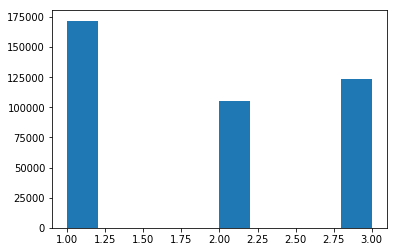

In [12]:
# distribution of maximum states
all_states = [i for i in range(len(P))]
peaks = [max(w) for w in all_walks]
print([sum([1 for i in peaks if i == j]) / len(peaks) for j in all_states])
plt.hist(peaks)

In [8]:
# expected time to reach a terminal state
walk_durations = [sum(i[:-1]) for i in all_times]
np.mean(walk_durations)

1.8890635940836649

In [103]:
# proportion of time in each state
all_states = [i for i in range(len(P))]
print(all_states)
flattend_walks = [t for w in all_walks for t in w]
print([sum([1 for i in flattend_walks if i == j]) / len(flattend_walks) for j in all_states])

[0, 1, 2, 3]
[0.14012819990573494, 0.4200233016928093, 0.2798951017870744, 0.15995339661438135]


#### alternative version of simulation for loop
Performs fixed number of random walks, rather than steps (a random walk consisting of multiple steps). Doesn't work if there are no terminal states - will go forever.

In [ ]:
for iteration in tqdm(range(total_iterations)):
    if isinstance(starting_state, int):
        i = starting_state
    else:
        i = generate_state(starting_state_C)
    walk = [i]
    while i not in terminal_states:
        i = generate_state(PC[i])
        walk.append(i)
    final_states.append(i)
    all_walks.append(walk)